In [125]:
%cd ../src

/Users/ivamilojkovic/Breast-Cancer-Analysis/src


In [126]:
import pandas as pd
import pickle, os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import normalize

plt.style.use('ggplot')
sns.set_theme()
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

import warnings
warnings.filterwarnings('ignore')

# CRIS Clinical Data

In [127]:
# Load one sheet/table about DFS
df_clinical = pd.read_excel(r'../data/gmql_grch38_annotations.xlsx', engine='openpyxl')

# Rename tcga_id columns
df_clinical.rename(columns={'aliquot_id': 'Patient ID'}, inplace=True)

# Drop some columns
cols_to_drop = set(df_clinical.columns)-set(['overall_survival_months_consensus', 'overall_survival_status_consensus', 'overall_survival_status_consensus_number', 'Patient ID', 'is_mucinous'])
df_clinical.drop(columns=list(cols_to_drop), inplace=True)

df_clinical.head()

,Patient ID,is_mucinous,overall_survival_months_consensus,overall_survival_status_consensus,overall_survival_status_consensus_number
0,TCGA-4N-A93T-01A-11R-A37K-07,NO,4.80,0:LIVING,0.0
1,TCGA-4T-AA8H-01A-11R-A41B-07,YES,12.65,0:LIVING,0.0
2,TCGA-5M-AAT5-01A-21R-A41B-07,NO,NaN,NaN,NaN
3,TCGA-5M-AAT6-01A-11R-A41B-07,NO,9.53,1:DECEASED,1.0
4,TCGA-5M-AATA-01A-31R-A41B-07,NO,NaN,NaN,NaN


In [128]:
# Load the multilabel dataset (contains genes, correlations)
labels = ['CRIS.A', 'CRIS.B', 'CRIS.C', 'CRIS.D', 'CRIS.E']
with open('../data/tcga_cris_raw_24356_620samples.pkl', 'rb') as file:
    df_multi = pickle.load(file) 

print(df_multi.shape)
df_multi.head()

(620, 24363)


,Patient ID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,...,ZYG11B,ZYX,ZZEF1,ZZZ3,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E,Subtype-from Parker centroids
0,TCGA-4N-A93T-01A-11R-A37K-07,31,75,996,3484,22,2,57,2400,2108,...,685,10621,2798,931,0.049577,-0.023935,0.189015,-0.097154,0.037806,CRIS.C
1,TCGA-4T-AA8H-01A-11R-A41B-07,1,12,876,1911,3,74,27,1663,2176,...,979,6497,4354,904,0.108729,0.041915,-0.019741,-0.173642,-0.105552,CRIS.A
2,TCGA-5M-AAT4-01A-11R-A41B-07,1,10,820,5888,5,37,186,2845,3123,...,1099,10500,2748,1582,-0.158505,0.008226,-0.010710,-0.035492,-0.196177,CRIS.B
3,TCGA-5M-AAT5-01A-21R-A41B-07,1,9,1359,5075,10,7,89,2714,2031,...,1208,8551,2253,1051,-0.151964,-0.141232,-0.149884,0.043142,-0.118708,CRIS.D
4,TCGA-5M-AAT6-01A-11R-A41B-07,6,32,21,11532,24,5,282,1540,1546,...,798,10001,2284,1316,0.040728,0.181194,-0.193775,0.040028,-0.084572,CRIS.B


In [129]:
# Merge the dataframes based on the 'ID' column (keep in mind, some NaNs will appear)
merged_df = pd.merge(df_multi, df_clinical, on=['Patient ID'], how='left')
print('Unique values in overall survival columns: ', merged_df['overall_survival_status_consensus'].unique())
print(merged_df.shape)
merged_df.head()

Unique values in overall survival columns:  ['0:LIVING' nan '1:DECEASED']
(620, 24367)


,Patient ID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,...,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E,Subtype-from Parker centroids,is_mucinous,overall_survival_months_consensus,overall_survival_status_consensus,overall_survival_status_consensus_number
0,TCGA-4N-A93T-01A-11R-A37K-07,31,75,996,3484,22,2,57,2400,2108,...,0.049577,-0.023935,0.189015,-0.097154,0.037806,CRIS.C,NO,4.80,0:LIVING,0.0
1,TCGA-4T-AA8H-01A-11R-A41B-07,1,12,876,1911,3,74,27,1663,2176,...,0.108729,0.041915,-0.019741,-0.173642,-0.105552,CRIS.A,YES,12.65,0:LIVING,0.0
2,TCGA-5M-AAT4-01A-11R-A41B-07,1,10,820,5888,5,37,186,2845,3123,...,-0.158505,0.008226,-0.010710,-0.035492,-0.196177,CRIS.B,NaN,NaN,NaN,NaN
3,TCGA-5M-AAT5-01A-21R-A41B-07,1,9,1359,5075,10,7,89,2714,2031,...,-0.151964,-0.141232,-0.149884,0.043142,-0.118708,CRIS.D,NO,NaN,NaN,NaN
4,TCGA-5M-AAT6-01A-11R-A41B-07,6,32,21,11532,24,5,282,1540,1546,...,0.040728,0.181194,-0.193775,0.040028,-0.084572,CRIS.B,NO,9.53,1:DECEASED,1.0


In [130]:
# Add new columns linked to time (5 years in this case)
merged_df['ALIVE FOR MORE THAN 5 YEARS'] = (merged_df['overall_survival_status_consensus'] == '0:LIVING') & (merged_df['overall_survival_months_consensus'] > 5*12)
merged_df['DECEASED WITHIN 5 YEARS'] = (merged_df['overall_survival_status_consensus'] == '1:DECEASED') & (merged_df['overall_survival_months_consensus'] <= 5*12)

merged_df['ALIVE FOR MORE THAN 10 YEARS'] = (merged_df['overall_survival_status_consensus'] == '0:LIVING') & (merged_df['overall_survival_months_consensus'] > 10*12)
merged_df['DECEASED WITHIN 10 YEARS'] = (merged_df['overall_survival_status_consensus'] == '1:DECEASED') & (merged_df['overall_survival_months_consensus'] <= 10*12)
merged_df

,Patient ID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,...,CRIS.E,Subtype-from Parker centroids,is_mucinous,overall_survival_months_consensus,overall_survival_status_consensus,overall_survival_status_consensus_number,ALIVE FOR MORE THAN 5 YEARS,DECEASED WITHIN 5 YEARS,ALIVE FOR MORE THAN 10 YEARS,DECEASED WITHIN 10 YEARS
0,TCGA-4N-A93T-01A-11R-A37K-07,31,75,996,3484,22,2,57,2400,2108,...,0.037806,CRIS.C,NO,4.80,0:LIVING,0.0,False,False,False,False
1,TCGA-4T-AA8H-01A-11R-A41B-07,1,12,876,1911,3,74,27,1663,2176,...,-0.105552,CRIS.A,YES,12.65,0:LIVING,0.0,False,False,False,False
2,TCGA-5M-AAT4-01A-11R-A41B-07,1,10,820,5888,5,37,186,2845,3123,...,-0.196177,CRIS.B,NaN,NaN,NaN,NaN,False,False,False,False
3,TCGA-5M-AAT5-01A-21R-A41B-07,1,9,1359,5075,10,7,89,2714,2031,...,-0.118708,CRIS.D,NO,NaN,NaN,NaN,False,False,False,False
4,TCGA-5M-AAT6-01A-11R-A41B-07,6,32,21,11532,24,5,282,1540,1546,...,-0.084572,CRIS.B,NO,9.53,1:DECEASED,1.0,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,TCGA-QL-A97D-01A-12R-A41B-07,3,24,781,7087,5,2,185,1928,3574,...,0.007429,CRIS.E,NaN,NaN,NaN,NaN,False,False,False,False
616,TCGA-RU-A8FL-01A-11R-A37K-07,1,0,686,2369,4,1,59,2402,2835,...,0.057920,CRIS.C,NO,38.67,0:LIVING,0.0,False,False,False,False
617,TCGA-SS-A7HO-01A-21R-A37K-07,2,13,2298,8187,18,1,300,5160,2863,...,0.053409,CRIS.D,NO,60.09,0:LIVING,0.0,True,False,False,False
618,TCGA-T9-A92H-01A-11R-A37K-07,2,9,1761,5286,13,5,148,2432,2966,...,-0.059630,CRIS.C,NO,11.89,0:LIVING,0.0,False,False,False,False


In [131]:
# Connect the original multilabel dataset and previously formed DataFrame with DFS and OS information
df_multi_merged = merged_df.drop(columns=merged_df.columns[1:-14])
df_multi_merged

,Patient ID,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E,Subtype-from Parker centroids,is_mucinous,overall_survival_months_consensus,overall_survival_status_consensus,overall_survival_status_consensus_number,ALIVE FOR MORE THAN 5 YEARS,DECEASED WITHIN 5 YEARS,ALIVE FOR MORE THAN 10 YEARS,DECEASED WITHIN 10 YEARS
0,TCGA-4N-A93T-01A-11R-A37K-07,0.049577,-0.023935,0.189015,-0.097154,0.037806,CRIS.C,NO,4.80,0:LIVING,0.0,False,False,False,False
1,TCGA-4T-AA8H-01A-11R-A41B-07,0.108729,0.041915,-0.019741,-0.173642,-0.105552,CRIS.A,YES,12.65,0:LIVING,0.0,False,False,False,False
2,TCGA-5M-AAT4-01A-11R-A41B-07,-0.158505,0.008226,-0.010710,-0.035492,-0.196177,CRIS.B,NaN,NaN,NaN,NaN,False,False,False,False
3,TCGA-5M-AAT5-01A-21R-A41B-07,-0.151964,-0.141232,-0.149884,0.043142,-0.118708,CRIS.D,NO,NaN,NaN,NaN,False,False,False,False
4,TCGA-5M-AAT6-01A-11R-A41B-07,0.040728,0.181194,-0.193775,0.040028,-0.084572,CRIS.B,NO,9.53,1:DECEASED,1.0,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,TCGA-QL-A97D-01A-12R-A41B-07,-0.158747,-0.053225,-0.078349,-0.241729,0.007429,CRIS.E,NaN,NaN,NaN,NaN,False,False,False,False
616,TCGA-RU-A8FL-01A-11R-A37K-07,-0.251466,-0.086701,0.117427,-0.062215,0.057920,CRIS.C,NO,38.67,0:LIVING,0.0,False,False,False,False
617,TCGA-SS-A7HO-01A-21R-A37K-07,-0.189990,-0.107892,-0.125795,0.431779,0.053409,CRIS.D,NO,60.09,0:LIVING,0.0,True,False,False,False
618,TCGA-T9-A92H-01A-11R-A37K-07,-0.042662,-0.068844,0.183324,-0.122212,-0.059630,CRIS.C,NO,11.89,0:LIVING,0.0,False,False,False,False


In [132]:
# Check how many rows have NaNs
df_multi_merged.isna().sum(axis=0)

Patient ID                                   0
CRIS.A                                       0
CRIS.B                                       0
CRIS.C                                       0
CRIS.D                                       0
CRIS.E                                       0
Subtype-from Parker centroids                0
is_mucinous                                 74
overall_survival_months_consensus           83
overall_survival_status_consensus           84
overall_survival_status_consensus_number    84
ALIVE FOR MORE THAN 5 YEARS                  0
DECEASED WITHIN 5 YEARS                      0
ALIVE FOR MORE THAN 10 YEARS                 0
DECEASED WITHIN 10 YEARS                     0
dtype: int64

In [133]:
# Remove NaN rows and check if they are removed
df_multi_merged.dropna(inplace=True)
df_multi_merged.isna().sum()

Patient ID                                  0
CRIS.A                                      0
CRIS.B                                      0
CRIS.C                                      0
CRIS.D                                      0
CRIS.E                                      0
Subtype-from Parker centroids               0
is_mucinous                                 0
overall_survival_months_consensus           0
overall_survival_status_consensus           0
overall_survival_status_consensus_number    0
ALIVE FOR MORE THAN 5 YEARS                 0
DECEASED WITHIN 5 YEARS                     0
ALIVE FOR MORE THAN 10 YEARS                0
DECEASED WITHIN 10 YEARS                    0
dtype: int64

# Creating DataFrames with Model Predictions

Since 6 models were selected each one of them gives prediction which will be used to create new datasets. These datasets will contain DFS, OS information, ground truth subtype from PAM50, information if a sample is predicted as LumA, taking into consideration the rank of the prediction (primary or secondary).

In [134]:
from data_preprocessing import remove_extreme

# Load the multilabel dataset (contains genes, correlations)
labels = ['CRIS.A', 'CRIS.B', 'CRIS.C', 'CRIS.D', 'CRIS.E']
with open('../data/tcga_cris_raw_24356_620samples.pkl', 'rb') as file:
    data = pickle.load(file) 
    X = data.drop(columns=['Patient ID',
                           'Subtype-from Parker centroids'] + labels, inplace=False)
    y_orig = data['Subtype-from Parker centroids']
    y_pam50 = data['Subtype-from Parker centroids']

# Remove extreme values (genes, samples) from initial preprocessing
X, potential_samples_to_remove, \
    feat_to_remove, feat_to_keep = remove_extreme(X, change_X = True)

# Take labels on whole dataset for PAM50
y_corr = data[labels]
y_corr_non_neg = discard_negative_correlations(y_corr)

# M-cut strategy to assign labels on whole dataset
y_mcut_labels, _ = m_cut_strategy_class_assignment(y_corr, non_neg_values=True)
y_mcut_labels_neg, _ = m_cut_strategy_class_assignment(y_corr, non_neg_values=False)

# Check if there are samples with no labels after mcut
samples_no_labels = y_mcut_labels.sum(axis=1) == 0
samples_no_labels_idx = y_mcut_labels.sum(axis=1)[samples_no_labels].index

if samples_no_labels.sum() > 0:
    for i in list(samples_no_labels_idx):
        y_mcut_labels.loc[i, y_pam50.iloc[samples_no_labels_idx][i]] = 1


# Compute labels from two strategies (M-cut and 5th percentile)
y_mcut_5perc_labels, threshs = create_mcut_nth_percentile_labels(
    m_cut_labels=y_mcut_labels,
    correlations=y_corr_non_neg,
    y=y_pam50,
    keep_primary=False,
    N=5
)

X_train, X_test, \
y_train_pam50, y_test_pam50, \
y_train_mcut, y_test_mcut, \
y_train_orig, y_test_orig, \
y_train_5perc, y_test_5perc, \
y_train_corr, y_test_corr = \
    train_test_split(X, y_pam50, y_mcut_labels, y_orig, 
                    y_mcut_5perc_labels, y_corr_non_neg, test_size=0.3, random_state=1, stratify=y_pam50)

# Data standardization | normalization
X_train = X_train.divide(X_train.sum(axis=1), axis=0) * 1e6
X_test = X_test.divide(X_test.sum(axis=1), axis=0) * 1e6
scaler = FunctionTransformer(log_transform)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Load selected features
# with open('../data/cris/new2_without_corr_removed_feat_select_gt_40_perc_occur.pkl', 'rb') as file:
#     selected_feat = list(pickle.load(file))
# '../data/cris_rare_feat_750_CRIS.csv', 'rb') as file:
selected_feat = pd.read_csv('../data/cris_rare_feat_750_CRIS.csv', index_col=0).values
selected_feat = [elem[0] for elem in selected_feat]

X_train_scaled_selected = X_train_scaled[selected_feat]
X_test_scaled_selected = X_test_scaled[selected_feat]

# One-hot encoding of original and PAM50 labels
y_train_orig = pd.get_dummies(y_train_orig)
y_test_orig = pd.get_dummies(y_test_orig)
y_train_pam50 = pd.get_dummies(y_train_pam50)
y_test_pam50_orig = y_test_pam50
y_test_pam50 = pd.get_dummies(y_test_pam50)

# Merged train and test
X_scaled_selected = pd.concat([X_train_scaled_selected, X_test_scaled_selected], axis=0)
X_scaled_selected = X_scaled_selected.sort_index()


There are 0 columns with more than 80% of Null values!
There are 24356 columns with more than 20% of count values greater than 4!


CRIS.A
0.04104173254999999
25:  0.07965765524999999
50:  0.10927497199999997
75:  0.13320883225000002

Cardinality:  32
Minimal correlation:  0.038437477
CRIS.B
0.04325135300000005
25:  0.08043445999999999
50:  0.10587089100000002
75:  0.16209544499999995

Cardinality:  41
Minimal correlation:  0.02699577799999997
CRIS.C
0.029402218950000038
25:  0.07724558649999999
50:  0.1063539685
75:  0.13412499500000002

Cardinality:  34
Minimal correlation:  0.012689142000000042
CRIS.D
0.04981789890000001
25:  0.06320547249999997
50:  0.09646447450000001
75:  0.11980290425000001

Cardinality:  38
Minimal correlation:  0.022516423000000008
CRIS.E
0.030972360000000032
25:  0.09056645299999999
50:  0.11322478999999996
75:  0.14750792000000001

Cardinality:  45
Minimal correlation:  0.018635427999999954


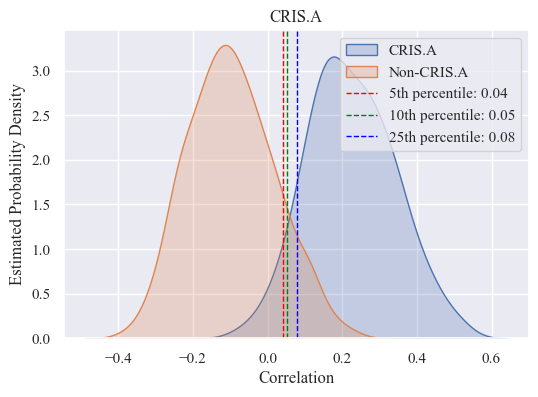

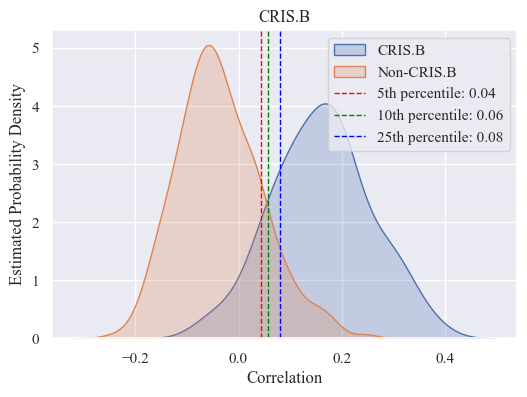

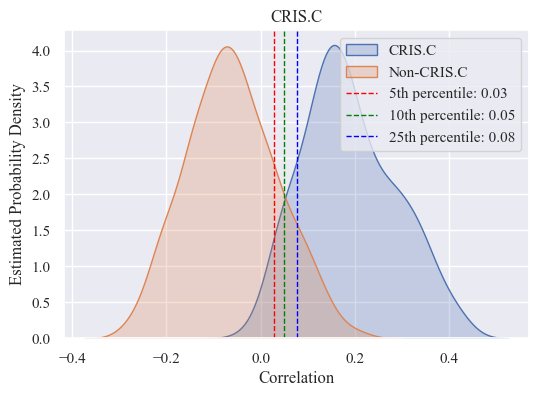

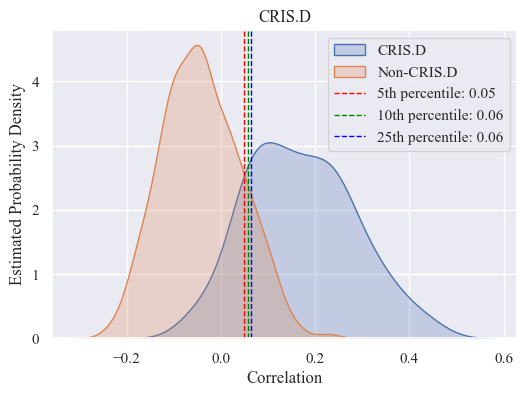

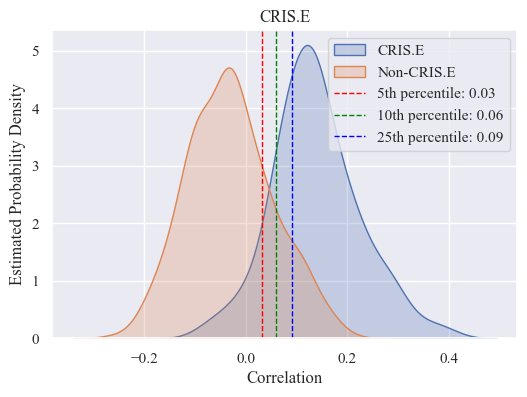

In [135]:
# List of target classes
target_classes = labels
filter_type_mcut = y_mcut_labels

df_multi = data
threshs = pd.Series(threshs, index=df_multi.index)

# Create plots for each target class
for i, target_class in enumerate(target_classes):
    print(target_class)
    # sns.set(style="white")
    plt.figure(figsize=(6, 4))
    target_class_df = df_multi.loc[df_multi['Subtype-from Parker centroids'] == target_class, :]
    mcut_target_class_df = filter_type_mcut.loc[df_multi['Subtype-from Parker centroids'] == target_class, :][target_classes]   
    target_idx = mcut_target_class_df[mcut_target_class_df[target_class] == 1].index
    target_thresh = threshs[target_idx].mean()   

    not_target_class_df = df_multi.loc[df_multi['Subtype-from Parker centroids'] != target_class, :]
    mcut_not_target_class_df = filter_type_mcut.loc[df_multi['Subtype-from Parker centroids'] != target_class, :][target_classes]   
    not_target_idx = mcut_not_target_class_df[mcut_not_target_class_df[target_class] != 1].index
    not_target_thresh = threshs[not_target_idx].mean()  
      
    sns.kdeplot(data=target_class_df[target_class].drop(columns=target_class), label=f"{target_class}", shade=True)
    sns.kdeplot(data=not_target_class_df[target_class],label=f"Non-{target_class}" , shade=True)
    
    # plt.axvline(intersections[i], color='red', linestyle='--', label=f'Intersection: {intersections[i]:.2f}')
    secondary_target_corr = df_multi.loc[df_multi['Subtype-from Parker centroids'] != target_class, :][target_class]
    secondary_target_label = filter_type_mcut.loc[df_multi['Subtype-from Parker centroids'] != target_class, :][target_class]
    secondary_target_corr = secondary_target_corr[secondary_target_label==1]
    print(secondary_target_corr.quantile(0.05))

    print('25: ',secondary_target_corr.quantile(0.25))
    print('50: ',secondary_target_corr.quantile(0.5))
    print('75: ',secondary_target_corr.quantile(0.75))

    print('\nCardinality: ', secondary_target_corr.shape[0])
    print('Minimal correlation: ', secondary_target_corr.min())

    plt.axvline(secondary_target_corr.quantile(0.05), color='red', linestyle='--', label=f'5th percentile: {secondary_target_corr.quantile(0.05):.2f}', linewidth=1)
    plt.axvline(secondary_target_corr.quantile(0.10), color='green', linestyle='--', label=f'10th percentile: {secondary_target_corr.quantile(0.1):.2f}', linewidth=1)
    plt.axvline(secondary_target_corr.quantile(0.25), color='blue', linestyle='--', label=f'25th percentile: {secondary_target_corr.quantile(0.25):.2f}', linewidth=1)
    # plt.axvline(not_target_thresh, color='blue', linestyle='--', label=f'Intersection: {not_target_thresh:.2f}', linewidth=1)

    plt.xlabel("Correlation")
    plt.ylabel("Estimated Probability Density")
    plt.title(f"{target_class}")
    plt.legend()


Text(0, 0.5, '')

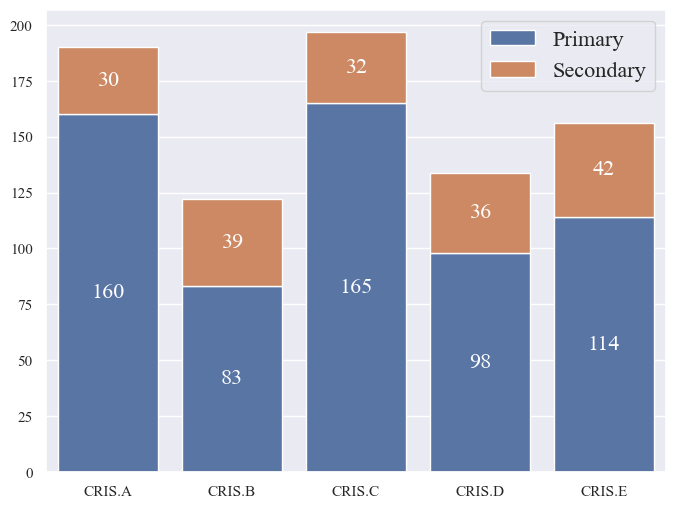

In [136]:
# Class distribution (counts) comparison
ax = plt.figure(figsize=(8,6))

df_compare = pd.DataFrame({
    'Primary': data['Subtype-from Parker centroids'].value_counts(),
    'Secondary': y_mcut_5perc_labels.sum(axis=0) - data['Subtype-from Parker centroids'].value_counts()
    }, 
    index=y_mcut_labels.columns)

palette = sns.color_palette()

# Plot the stacked bar chart using the custom palette
ax = sns.barplot(data=df_compare, x=df_compare.index, y='Primary', label='Primary',color=palette[0])
ax = sns.barplot(data=df_compare, x=df_compare.index, y='Secondary', label='Secondary', bottom=df_compare['Primary'],color=palette[1])

# Add values inside the bars
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=16, color='white')


# Show the legend
ax.legend(fontsize=16)
ax.set_ylabel('')


In [137]:
# Get test indices (here we are using only labels obtained with M-cut strategy and 5th percentile filtering)
test_idx = y_test_5perc.index
test_tcga_idx = df_multi.iloc[test_idx, 0]
test_tcga_idx

96     TCGA-AA-3556-01A-01R-0821-07
232    TCGA-AD-6889-01A-11R-1928-07
69     TCGA-AA-3514-01A-02R-0821-07
551    TCGA-F4-6806-01A-11R-1839-07
430    TCGA-CM-6163-01A-11R-1653-07
                   ...             
486    TCGA-DC-6158-01A-11R-1660-07
465    TCGA-D5-6898-01A-11R-1928-07
184    TCGA-AA-A004-01A-01R-A00A-07
555    TCGA-F4-6854-01A-11R-1928-07
55     TCGA-A6-A567-01A-31R-A28H-07
Name: Patient ID, Length: 186, dtype: object

In [138]:
# path_cris_sl = '../final_results/CRIS/single-label/01-14-52/'

# # Loading the best models for each approach in single-label
# with open(os.path.join(path_cris_sl, 'bestmodel_XGBoost_run_01-09-2023_03:49:46.pkl'), 'rb') as f:
#     cris_model_xgb = pickle.load(f)

# with open(os.path.join(path_cris_sl, 'bestmodel_LogisticRegression_run_01-09-2023_01:15:05.pkl'), 'rb') as f:
#     cris_model_lr = pickle.load(f)

# with open(os.path.join(path_cris_sl, 'bestmodel_RandomForest_run_01-09-2023_01:42:48.pkl'), 'rb') as f:
#     cris_model_rf = pickle.load(f)

# with open(os.path.join(path_cris_sl, 'bestmodel_SVC_run_01-09-2023_01:59:53.pkl'), 'rb') as f:
#     cris_model_svm = pickle.load(f)

# path_cris_ml = '../final_results/CRIS/multi-label'
# path_cris_ml_pt = os.path.join(path_cris_ml, '04-09-2023_20:03:21')

# # Logistic Regression - all
# with open(os.path.join(path_cris_ml_pt, 'BR_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_lr_br = pickle.load(file)
# with open(os.path.join(path_cris_ml_pt, 'CC_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_lr_cc = pickle.load(file)
# with open(os.path.join(path_cris_ml_pt, 'LP_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_lr_lp = pickle.load(file)

# # XGBoost - Binary Relevance
# with open(os.path.join(path_cris_ml_pt, 'BR_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_xgb_br = pickle.load(file)

# # SVM - all
# with open(os.path.join(path_cris_ml_pt, 'BR_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_svc_br = pickle.load(file)
# with open(os.path.join(path_cris_ml_pt, 'CC_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_svc_cc = pickle.load(file)
# with open(os.path.join(path_cris_ml_pt, 'LP_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_svc_lp = pickle.load(file)

# ##### Ensemble
# path_cris_ml_ens = os.path.join(path_cris_ml, '05-09-2023_02:32:10')
# with open(os.path.join(path_cris_ml_ens, 'EnsembleCC_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_ecc_lr = pickle.load(file)
# with open(os.path.join(path_cris_ml_ens, 'EnsembleRakel_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_er_svm = pickle.load(file)
# with open(os.path.join(path_cris_ml_ens, 'EnsembleCC_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     cris_ml_model_ecc_svm = pickle.load(file)

### CRIS with ReRa 

In [139]:
path_cris_sl = '../final_results/CRIS/single-label/rera/fs_750/21-07-13/'

# Loading the best models for each approach in single-label
with open(os.path.join(path_cris_sl, 'bestmodel_XGBoost_run_16-10-2023_00:20:29.pickle'), 'rb') as f:
    cris_model_xgb = pickle.load(f)

with open(os.path.join(path_cris_sl, 'bestmodel_LogisticRegression_run_16-10-2023_01:44:05.pickle'), 'rb') as f:
    cris_model_lr = pickle.load(f)

with open(os.path.join(path_cris_sl, 'bestmodel_RandomForest_run_16-10-2023_00:10:37.pickle'), 'rb') as f:
    cris_model_rf = pickle.load(f)

with open(os.path.join(path_cris_sl, 'bestmodel_SVC_run_15-10-2023_23:24:39.pickle'), 'rb') as f:
    cris_model_svm = pickle.load(f)

path_cris_ml = '../final_results/CRIS/multi-label/feat_select_ReRa/feat_select_750/18-10-2023_01:42:37/'

# Logistic Regression - all
with open(os.path.join(path_cris_ml, 'BR_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_lr_br = pickle.load(file)
with open(os.path.join(path_cris_ml, 'CC_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_lr_cc = pickle.load(file)
with open(os.path.join(path_cris_ml, 'LP_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_lr_lp = pickle.load(file)

# XGBoost - Label Powerset
with open(os.path.join(path_cris_ml, 'LP_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_xgb_lp = pickle.load(file)

# SVM - all
with open(os.path.join(path_cris_ml, 'BR_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_svc_br = pickle.load(file)
with open(os.path.join(path_cris_ml, 'CC_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_svc_cc = pickle.load(file)
with open(os.path.join(path_cris_ml, 'LP_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_svc_lp = pickle.load(file)

##### Ensemble
with open(os.path.join(path_cris_ml, 'EnsembleCC_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_ecc_lr = pickle.load(file)
with open(os.path.join(path_cris_ml, 'EnsembleRakel_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_er_lr = pickle.load(file)
with open(os.path.join(path_cris_ml, 'EnsembleRakel_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_er_svm = pickle.load(file)
with open(os.path.join(path_cris_ml, 'EnsembleCC_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    cris_ml_model_ecc_svm = pickle.load(file)

In [175]:
from sklearn.metrics import accuracy_score
# Define a mapping dictionary
mapping = {0: 'CRIS.A', 1: 'CRIS.B', 2: 'CRIS.C', 3: 'CRIS.D', 4: 'CRIS.E'}

## Get the predictions and probabilities for each model and set the original test indices
dataset_type = 'whole' # ['whole', 'test']
if dataset_type == 'whole':
    X_test_scaled_selected = X_scaled_selected
    y_test_5perc = y_mcut_5perc_labels

############################### XGBoost ###############################
# ------- Multi-label -------
xgb_lp_preds = cris_ml_model_xgb_lp.predict(X_test_scaled_selected).toarray()
xgb_lp_preds = pd.DataFrame(xgb_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
xgb_lp_prob_preds = cris_ml_model_xgb_lp.predict_proba(X_test_scaled_selected).toarray()
xgb_lp_prob_preds = pd.DataFrame(xgb_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# xgb_lp_preds = cris_ml_model_xgb_lp.predict(X_test_scaled_selected).toarray()
# xgb_lp_preds = pd.DataFrame(xgb_lp_preds, index=y_test_5perc.index)
# xgb_lp_prob_preds = cris_ml_model_xgb_lp.predict_proba(X_test_scaled_selected).toarray()
# xgb_lp_prob_preds = pd.DataFrame(xgb_lp_prob_preds, index=y_test_5perc.index)

# ------- Single-label -------
xgb_preds = cris_model_xgb.predict(X_test_scaled_selected)
xgb_preds = pd.Series(xgb_preds, index=y_test_5perc.index).map(mapping)

# ############################### Logistic Regression ###############################
# # ------- Multi-label -------
lr_br_preds = cris_ml_model_lr_br.predict(X_test_scaled_selected).toarray()
lr_br_preds = pd.DataFrame(lr_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
lr_br_prob_preds = cris_ml_model_lr_br.predict_proba(X_test_scaled_selected).toarray()
lr_br_prob_preds = pd.DataFrame(lr_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_cc_preds = cris_ml_model_lr_cc.predict(X_test_scaled_selected).toarray()
lr_cc_preds = pd.DataFrame(lr_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
lr_cc_prob_preds = cris_ml_model_lr_cc.predict_proba(X_test_scaled_selected).toarray()
lr_cc_prob_preds = pd.DataFrame(lr_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_lp_preds = cris_ml_model_lr_lp.predict(X_test_scaled_selected).toarray()
lr_lp_preds = pd.DataFrame(lr_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
lr_lp_prob_preds = cris_ml_model_lr_lp.predict_proba(X_test_scaled_selected).toarray()
lr_lp_prob_preds = pd.DataFrame(lr_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

er_lr_preds = cris_ml_model_er_lr.predict(X_test_scaled_selected).todense()
er_lr_preds = pd.DataFrame(er_lr_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
er_lr_prob_preds = cris_ml_model_er_lr.predict_proba(X_test_scaled_selected).todense()
er_lr_prob_preds = pd.DataFrame(er_lr_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

ecc_lr_preds = cris_ml_model_ecc_lr.predict(X_test_scaled_selected)
ecc_lr_preds = pd.DataFrame(ecc_lr_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
ecc_lr_prob_preds = cris_ml_model_ecc_lr.predict_proba(X_test_scaled_selected)
ecc_lr_prob_preds = normalize(np.array([ecc_lr_prob_preds[i][:, 1] for i in range(5)]).transpose(), axis=1, norm='l1')
ecc_lr_prob_preds = pd.DataFrame(ecc_lr_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# ------- Single-label -------
lr_preds = cris_model_lr.predict(X_test_scaled_selected)
lr_preds = pd.Series(lr_preds, index=y_test_5perc.index).map(mapping)

# ############################### SVM ###############################
# # ------- Multi-label -------
svm_br_preds = cris_ml_model_svc_br.predict(X_test_scaled_selected).toarray()
svm_br_preds = pd.DataFrame(svm_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
svm_br_prob_preds = cris_ml_model_svc_br.predict_proba(X_test_scaled_selected).toarray()
svm_br_prob_preds = pd.DataFrame(svm_br_prob_preds, index=y_test_5perc.index)

svm_cc_preds = cris_ml_model_svc_cc.predict(X_test_scaled_selected).toarray()
svm_cc_preds = pd.DataFrame(svm_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
svm_cc_prob_preds = cris_ml_model_svc_cc.predict_proba(X_test_scaled_selected).toarray()
svm_cc_prob_preds = pd.DataFrame(svm_cc_prob_preds, index=y_test_5perc.index)

svm_lp_preds = cris_ml_model_svc_lp.predict(X_test_scaled_selected).toarray()
svm_lp_preds = pd.DataFrame(svm_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
svm_lp_prob_preds = cris_ml_model_svc_lp.predict_proba(X_test_scaled_selected).toarray()
svm_lp_prob_preds = pd.DataFrame(svm_lp_prob_preds, index=y_test_5perc.index)

er_svm_preds = cris_ml_model_er_svm.predict(X_test_scaled_selected).todense()
er_svm_preds = pd.DataFrame(er_svm_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
er_svm_prob_preds = cris_ml_model_er_svm.predict_proba(X_test_scaled_selected).todense()
er_svm_prob_preds = pd.DataFrame(er_svm_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

ecc_svm_preds = cris_ml_model_ecc_svm.predict(X_test_scaled_selected)
ecc_svm_preds = pd.DataFrame(ecc_svm_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
ecc_svm_prob_preds = cris_ml_model_ecc_svm.predict_proba(X_test_scaled_selected)
ecc_svm_prob_preds = normalize(np.array([ecc_svm_prob_preds[i][:, 1] for i in range(5)]).transpose(), axis=1, norm='l1')
ecc_svm_prob_preds = pd.DataFrame(ecc_svm_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# ------- Single-label -------
svm_preds = cris_model_svm.predict(X_test_scaled_selected)
svm_preds = pd.Series(svm_preds, index=y_test_5perc.index).map(mapping)

rf_preds = cris_model_rf.predict(X_test_scaled_selected)
rf_preds = pd.Series(rf_preds, index=y_test_5perc.index).map(mapping)

In [176]:
from sklearn.metrics import confusion_matrix
sns.set(font_scale=2)

# Plot confusion matrix
conf_mat = confusion_matrix(y_test_pam50_orig, xgb_preds) 
# conf_mat_norm = confusion_matrix(y_test, pred, normalize='true')
conf_mat_percentage = conf_mat / conf_mat.sum(axis=1).reshape(-1,1)

class_cnts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
class_percentages = ['{0:.2%}'.format(value) for value in conf_mat_percentage.flatten()]   
# class_cnt_norm = ['{0:.2f}'.format(value) for value in conf_mat_norm.flatten()]

labels = [f'{v1}\n{v2}' for \
            v1, v2 in zip(class_cnts, class_percentages)] # class_per
labels = np.asarray(labels).reshape(5,5)

fig = plt.figure(figsize=(15, 12))
df = pd.DataFrame(conf_mat_percentage, index = [i for i in xgb_lp_preds.columns], columns = [i for i in xgb_lp_preds.columns])
#sns.heatmap(df.div(df.values.sum()), annot=True)
sns.heatmap(df, annot=labels, fmt='', cmap='Greens')
plt.title('XGB')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('../data/cris/predictions/cris_cm_xgb' + '.png')

ValueError: Found input variables with inconsistent numbers of samples: [186, 620]

 ------ SCORES ------
Accuracy: 0.7580645161290323
MCCn: 0.6915983690696322

Scores (weighted) on the test set:

Precision: 0.7603200229103088
Recall: 0.7580645161290323
F1 score: 0.7536163859525369

Scores (micro) on the test set:
 
Precision: 0.7580645161290323
Recall: 0.7580645161290323
F1 score: 0.7580645161290323

Scores (macro) on the test set:
 
Precision: 0.7651192735158581
Recall: 0.7313482082488169
F1 score: 0.7425850187665795
Scores (per class) on the test set:
 
Precision: [0.83333333 0.68       0.9        0.65517241 0.58823529]
Recall: [0.78431373 0.80952381 0.72580645 0.79166667 0.71428571]
F1 score: [0.80808081 0.73913043 0.80357143 0.71698113 0.64516129]


<Figure size 2400x1000 with 0 Axes>

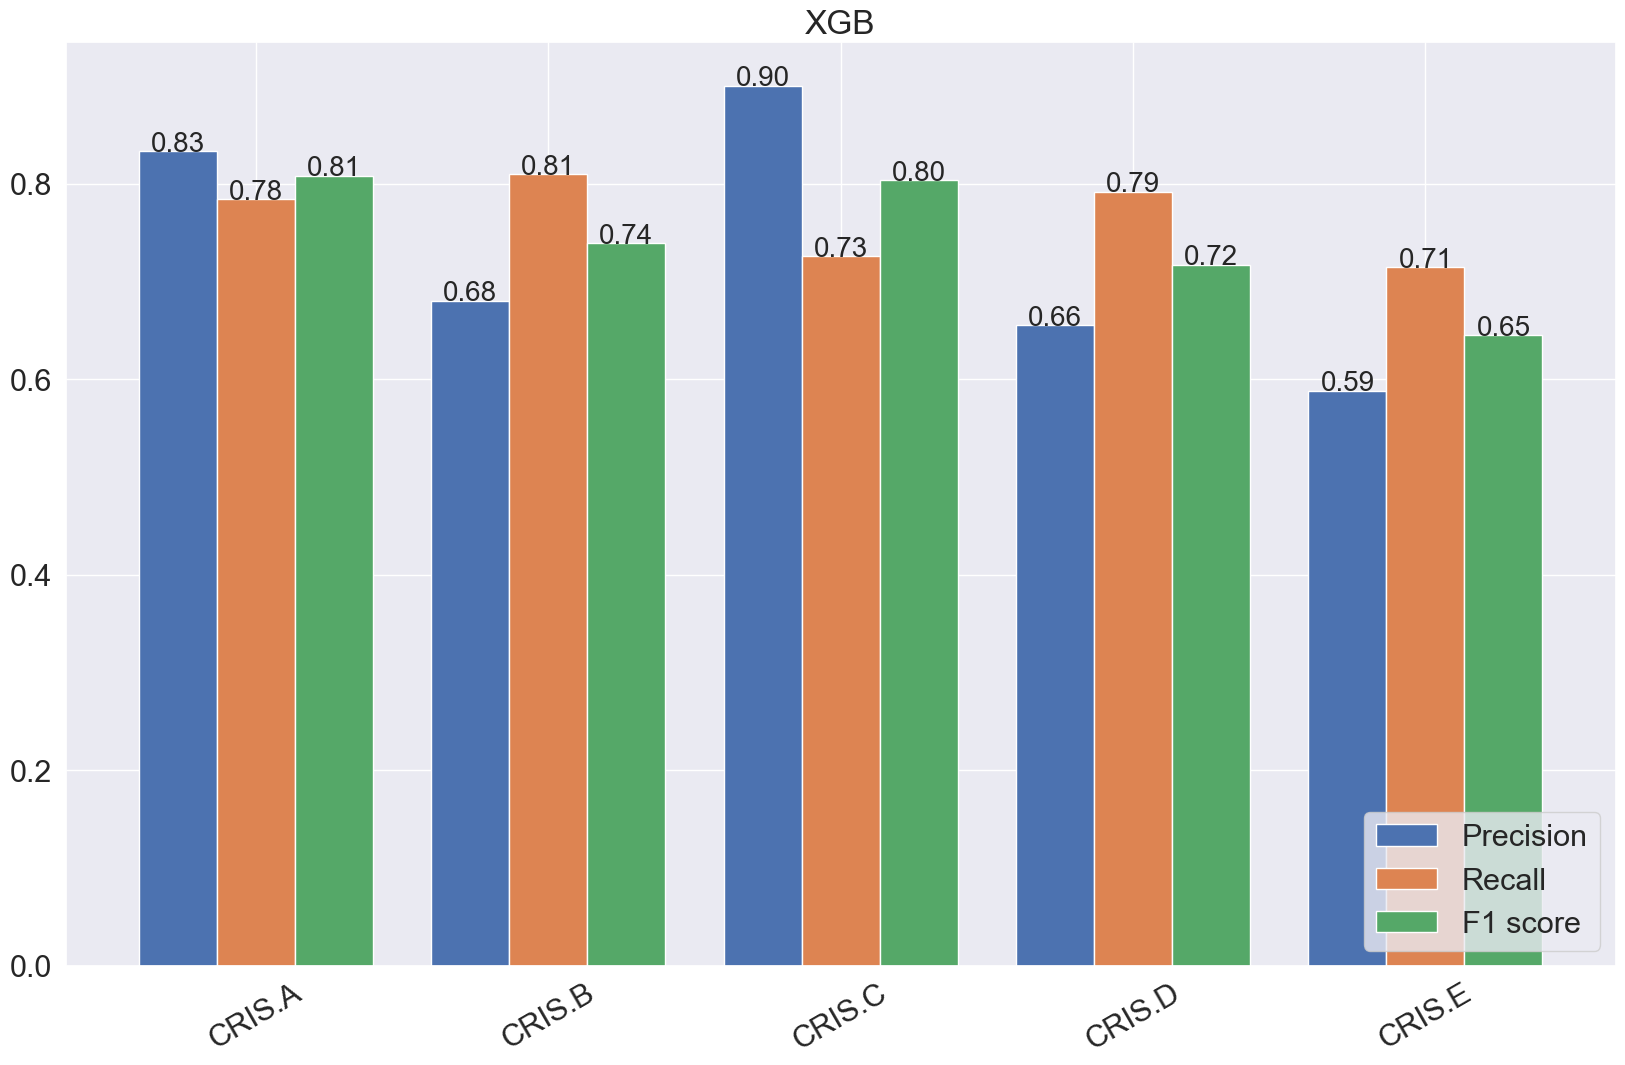

In [ ]:
from utils import cmp_metrics

test_metrics = cmp_metrics(y_test_pam50_orig, xgb_preds)

ax = plt.figure(figsize=(24, 10))
df_lr = pd.DataFrame({'Precision': test_metrics['Precision per class'],
                'Recall': test_metrics['Recall per class'],
                'F1 score': test_metrics['F1 score per class']}, 
                index=xgb_lp_preds.columns)
ax = df_lr.plot(kind='bar', rot=30, title='XGB', width=0.8)
# Add values above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=20)
plt.legend(loc='lower right')
plt.gcf().set_size_inches(20, 12)
plt.savefig('../data/cris/predictions/cris_bp_xgb' + '.png')

In [ ]:
def save_prediction(preds: pd.DataFrame, probs: pd.DataFrame) -> pd.DataFrame:

    # Take into account the rank of prediction i.e. labels
    ranked_indices = probs.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    ranked_corr_df = pd.DataFrame(ranked_indices.values.tolist(), columns=preds.columns, index=probs.index)
    rank_preds = preds * ranked_corr_df
    return rank_preds

save_prediction(xgb_lp_preds, xgb_lp_prob_preds).to_csv('../data/cris/predictions/xgb_lp_pred.csv', index=False)

save_prediction(lr_br_preds, lr_br_prob_preds).to_csv('../data/cris/predictions/lr_br_pred.csv', index=False)
save_prediction(lr_cc_preds, lr_cc_prob_preds).to_csv('../data/cris/predictions/lr_cc_pred.csv', index=False)
save_prediction(lr_lp_preds, lr_lp_prob_preds).to_csv('../data/cris/predictions/lr_lp_pred.csv', index=False)
save_prediction(ecc_lr_preds, ecc_lr_prob_preds).to_csv('../data/cris/predictions/lr_ecc_pred.csv', index=False)
save_prediction(er_lr_preds, er_lr_prob_preds).to_csv('../data/cris/predictions/lr_er_pred.csv', index=False)

save_prediction(svm_br_preds, svm_br_prob_preds).to_csv('../data/cris/predictions/svm_br_pred.csv', index=False)
save_prediction(svm_cc_preds, svm_cc_prob_preds).to_csv('../data/cris/predictions/svm_cc_pred.csv', index=False)
save_prediction(svm_lp_preds, svm_lp_prob_preds).to_csv('../data/cris/predictions/svm_lp_pred.csv', index=False)
save_prediction(ecc_svm_preds, ecc_svm_prob_preds).to_csv('../data/cris/predictions/svm_ecc_pred.csv', index=False)
save_prediction(er_svm_preds, er_svm_prob_preds).to_csv('../data/cris/predictions/svm_er_pred.csv', index=False)


In [ ]:
(y_mcut_5perc_labels.sum(axis=1) == 0).sum()

0

In [ ]:
idx = xgb_lp_preds[(save_prediction(xgb_lp_preds, xgb_lp_prob_preds).sum(axis=1) == 3)].index.tolist()
xgb_lp_preds[(save_prediction(xgb_lp_preds, xgb_lp_prob_preds).sum(axis=1) == 3)]

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
138,1,1,0,0,0
224,1,1,0,0,0
42,0,1,1,0,0
373,0,1,0,0,1
487,1,0,0,0,0
8,1,1,0,0,0
288,0,0,0,1,1
133,1,1,0,0,0
504,1,1,0,0,0
310,0,1,1,0,0


In [ ]:
save_prediction(xgb_lp_preds, xgb_lp_prob_preds).loc[idx, :]

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
138,1,2,0,0,0
224,2,1,0,0,0
42,0,2,1,0,0
373,0,1,0,0,2
487,3,0,0,0,0
8,2,1,0,0,0
288,0,0,0,2,1
133,1,2,0,0,0
504,1,2,0,0,0
310,0,1,2,0,0


In [ ]:
xgb_lp_prob_preds.loc[idx, :]

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
138,0.834818,0.691473,0.069633,0.114612,0.097301
224,0.591932,0.790280,0.070221,0.190102,0.067894
42,0.064552,0.436431,0.517806,0.390650,0.197432
373,0.275180,0.678919,0.081336,0.151520,0.648268
487,0.335149,0.304245,0.390516,0.334284,0.361390
8,0.725303,0.775761,0.068481,0.099462,0.117980
288,0.072558,0.361721,0.410782,0.456197,0.808668
133,0.946723,0.707843,0.033082,0.030084,0.021029
504,0.798143,0.504530,0.116772,0.118353,0.130782
310,0.121441,0.795400,0.531266,0.246436,0.149793


In [ ]:
x = save_prediction(xgb_lp_preds, xgb_lp_prob_preds).iloc[0,:]
x[x==1].index[0]

'CRIS.A'

In [ ]:
rest = save_prediction(xgb_lp_preds, xgb_lp_prob_preds)[save_prediction(xgb_lp_preds, xgb_lp_prob_preds)==1]
rest = [i[1] for i in rest.stack().index]
rest

['CRIS.A',
 'CRIS.A',
 'CRIS.D',
 'CRIS.A',
 'CRIS.C',
 'CRIS.C',
 'CRIS.A',
 'CRIS.A',
 'CRIS.E',
 'CRIS.C',
 'CRIS.D',
 'CRIS.D',
 'CRIS.D',
 'CRIS.B',
 'CRIS.D',
 'CRIS.D',
 'CRIS.D',
 'CRIS.C',
 'CRIS.B',
 'CRIS.C',
 'CRIS.A',
 'CRIS.D',
 'CRIS.A',
 'CRIS.A',
 'CRIS.C',
 'CRIS.B',
 'CRIS.C',
 'CRIS.E',
 'CRIS.D',
 'CRIS.C',
 'CRIS.C',
 'CRIS.E',
 'CRIS.A',
 'CRIS.A',
 'CRIS.A',
 'CRIS.C',
 'CRIS.A',
 'CRIS.D',
 'CRIS.D',
 'CRIS.B',
 'CRIS.B',
 'CRIS.E',
 'CRIS.B',
 'CRIS.A',
 'CRIS.C',
 'CRIS.A',
 'CRIS.C',
 'CRIS.C',
 'CRIS.B',
 'CRIS.A',
 'CRIS.E',
 'CRIS.A',
 'CRIS.C',
 'CRIS.E',
 'CRIS.C',
 'CRIS.C',
 'CRIS.C',
 'CRIS.E',
 'CRIS.A',
 'CRIS.C',
 'CRIS.E',
 'CRIS.B',
 'CRIS.C',
 'CRIS.B',
 'CRIS.A',
 'CRIS.A',
 'CRIS.C',
 'CRIS.E',
 'CRIS.C',
 'CRIS.C',
 'CRIS.E',
 'CRIS.E',
 'CRIS.A',
 'CRIS.C',
 'CRIS.D',
 'CRIS.C',
 'CRIS.B',
 'CRIS.C',
 'CRIS.E',
 'CRIS.A',
 'CRIS.D',
 'CRIS.C',
 'CRIS.A',
 'CRIS.E',
 'CRIS.E',
 'CRIS.A',
 'CRIS.B',
 'CRIS.D',
 'CRIS.C',
 'CRIS.D',
 'CRIS.C',

In [177]:
xgb_lp_prob_preds

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
0,0.087226,0.063813,0.863012,0.050891,0.115358
1,0.991406,0.007677,0.007481,0.005036,0.007942
2,0.003601,0.979514,0.016694,0.009202,0.004968
3,0.004400,0.007771,0.008754,0.990150,0.008328
4,0.007433,0.990765,0.004164,0.010210,0.004510
...,...,...,...,...,...
615,0.008635,0.007610,0.011639,0.007100,0.988551
616,0.003311,0.006486,0.988782,0.008736,0.015060
617,0.006668,0.016474,0.018985,0.989123,0.131480
618,0.018958,0.010453,0.985538,0.012858,0.018205


In [178]:
len(rest)

182

In [179]:
xgb_lp_prob_preds[save_prediction(xgb_lp_preds, xgb_lp_prob_preds)==1]

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
0,NaN,NaN,0.863012,NaN,NaN
1,0.991406,NaN,NaN,NaN,NaN
2,NaN,0.979514,NaN,NaN,NaN
3,NaN,NaN,NaN,0.990150,NaN
4,NaN,0.990765,NaN,NaN,NaN
...,...,...,...,...,...
615,NaN,NaN,NaN,NaN,0.988551
616,NaN,NaN,0.988782,NaN,NaN
617,NaN,NaN,NaN,0.989123,NaN
618,NaN,NaN,0.985538,NaN,NaN


In [180]:
xgb_lp_prob_preds[(save_prediction(xgb_lp_preds, xgb_lp_prob_preds).sum(axis=1) == 6)]

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
102,0.013780,0.954241,0.027274,0.965434,0.974165
110,0.026694,0.034957,0.947774,0.955948,0.936586
173,0.018046,0.030596,0.950858,0.940623,0.935278
206,0.023953,0.951173,0.028234,0.952703,0.930944
218,0.015974,0.956257,0.023009,0.949047,0.968867
236,0.018320,0.935393,0.025423,0.944293,0.953914
312,0.038312,0.958157,0.027928,0.931532,0.932498
325,0.013883,0.937010,0.955891,0.940261,0.024898
420,0.044829,0.938026,0.925654,0.904293,0.047252
436,0.038844,0.897634,0.893005,0.107673,0.918091


In [181]:
save_prediction(xgb_lp_preds, xgb_lp_prob_preds)[(save_prediction(xgb_lp_preds, xgb_lp_prob_preds).sum(axis=1) == 6)]

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
102,0,3,0,2,1
110,0,0,2,1,3
173,0,0,1,2,3
206,0,2,0,1,3
218,0,2,0,3,1
236,0,3,0,2,1
312,0,1,0,3,2
325,0,3,1,2,0
420,0,1,2,3,0
436,0,2,3,0,1


In [182]:
y_pam50.value_counts()

CRIS.C    165
CRIS.A    160
CRIS.E    114
CRIS.D     98
CRIS.B     83
Name: Subtype-from Parker centroids, dtype: int64

In [183]:
y_pam50[[18, 122, 130, 196, 204, 214, 272, 300, 388, 413, 487, 495, 507, 539, 567, 578, 601]]

18     CRIS.E
122    CRIS.B
130    CRIS.C
196    CRIS.D
204    CRIS.D
214    CRIS.E
272    CRIS.A
300    CRIS.B
388    CRIS.B
413    CRIS.E
487    CRIS.A
495    CRIS.E
507    CRIS.A
539    CRIS.D
567    CRIS.E
578    CRIS.D
601    CRIS.D
Name: Subtype-from Parker centroids, dtype: object

In [184]:
y_mcut_labels.loc[[18, 122, 130, 196, 204, 214, 272, 300, 388, 413, 487, 495, 507, 539, 567, 578, 601], :]

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
18,0,0,0,0,1
122,0,1,0,0,0
130,0,0,1,0,0
196,0,0,0,1,0
204,0,0,0,1,0
214,0,0,0,0,1
272,1,0,0,0,0
300,0,1,0,0,0
388,0,1,0,0,0
413,0,0,0,0,1


In [185]:
(y_mcut_labels.sum(axis=1) == 0).sum()

0

In [186]:
save_prediction(xgb_lp_preds, xgb_lp_prob_preds)

,CRIS.A,CRIS.B,CRIS.C,CRIS.D,CRIS.E
0,0,0,1,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,1,0,0,0
...,...,...,...,...,...
615,0,0,0,0,1
616,0,0,1,0,0
617,0,0,0,1,0
618,0,0,1,0,0


In [187]:
y_pam50

0      CRIS.C
1      CRIS.A
2      CRIS.B
3      CRIS.D
4      CRIS.B
        ...  
615    CRIS.E
616    CRIS.C
617    CRIS.D
618    CRIS.C
619    CRIS.A
Name: Subtype-from Parker centroids, Length: 620, dtype: object

In [188]:
y_true = y_mcut_5perc_labels.copy()
for i, row in y_mcut_5perc_labels.iterrows():
    for col in y_mcut_5perc_labels.columns:
        if row[col] == 1 and col != y_pam50[i]:
            y_true.loc[i, col] = 2

y_true.to_csv('../data/cris/predictions/ground_truth.csv', index=False)
y_true['CRIS label'] = y_pam50

y_true, save_prediction(svm_lp_preds, svm_lp_prob_preds)

(     CRIS.A  CRIS.B  CRIS.C  CRIS.D  CRIS.E CRIS label
 0         0       0       1       0       0     CRIS.C
 1         1       0       0       0       0     CRIS.A
 2         0       1       0       0       0     CRIS.B
 3         0       0       0       1       0     CRIS.D
 4         0       1       0       0       0     CRIS.B
 ..      ...     ...     ...     ...     ...        ...
 615       0       0       0       0       1     CRIS.E
 616       0       0       1       0       0     CRIS.C
 617       0       0       0       1       0     CRIS.D
 618       0       0       1       0       0     CRIS.C
 619       1       0       0       2       0     CRIS.A
 
 [620 rows x 6 columns],
      CRIS.A  CRIS.B  CRIS.C  CRIS.D  CRIS.E
 0         0       0       1       0       0
 1         1       0       0       0       0
 2         0       1       0       0       0
 3         0       0       0       1       0
 4         0       1       0       0       0
 ..      ...     ...     ...   

In [189]:
# Function to set "test" or "train"
def set_test_or_train(id_value):
    if str(id_value) in test_tcga_idx.values:
        return "test"
    else:
        return "train"
    
# Function to get custom sorted indices for each row
def rank_indices(row):
    return row.rank(ascending=False).astype(int)
    
def df_formatting(df: pd.DataFrame, preds: pd.DataFrame, probs: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    # Take into account the rank of prediction i.e. labels
    ranked_indices = probs.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    ranked_corr_df = pd.DataFrame(ranked_indices.values.tolist(), columns=preds.columns, index=probs.index)
    rank_preds = preds * ranked_corr_df

    # Create the new column using apply()
    df_new['TRAINING OR TESTING'] =  df_new["Patient ID"].apply(set_test_or_train)
    df_new.rename(columns={'Subtype-from Parker centroids': 'PAM50 SUBTYPE'}, inplace=True)
    df_new['IS CRIS.B'] = preds['CRIS.B'].astype('bool')
    df_new['IS CRIS.B PRIMARY'] = rank_preds['CRIS.B'] == 1
    df_new['IS CRIS.B SECONDARY'] = rank_preds['CRIS.B'] > 1

    return df_new

def df_add_single_label_formatting(df: pd.DataFrame, preds: pd.DataFrame):
    df_new = df.copy()
    df_new['IS CRIS.B (single-label)'] = preds == 'CRIS.B'
    return df_new

# Formatting the dataframes
df_xgb_lp = df_formatting(df_multi_merged, xgb_lp_preds, xgb_lp_prob_preds)

df_lr_br = df_formatting(df_multi_merged, lr_br_preds, lr_br_prob_preds)
df_lr_cc = df_formatting(df_multi_merged, lr_cc_preds, lr_cc_prob_preds)
df_lr_lp = df_formatting(df_multi_merged, lr_lp_preds, lr_lp_prob_preds)
df_er_lr = df_formatting(df_multi_merged, er_lr_preds, er_lr_prob_preds)
df_ecc_lr = df_formatting(df_multi_merged, ecc_lr_preds, ecc_lr_prob_preds)

df_svm_br = df_formatting(df_multi_merged, svm_br_preds, svm_br_prob_preds)
df_svm_cc = df_formatting(df_multi_merged, svm_cc_preds, svm_cc_prob_preds)
df_svm_lp = df_formatting(df_multi_merged, svm_lp_preds, svm_lp_prob_preds)
df_er_svm = df_formatting(df_multi_merged, er_svm_preds, er_svm_prob_preds)
df_ecc_svm = df_formatting(df_multi_merged, ecc_svm_preds, ecc_svm_prob_preds)

df_xgb_lp = df_add_single_label_formatting(df_xgb_lp, xgb_preds)

df_lr_br = df_add_single_label_formatting(df_lr_br, lr_preds)
df_lr_cc = df_add_single_label_formatting(df_lr_cc, lr_preds)
df_lr_lp = df_add_single_label_formatting(df_lr_lp, lr_preds)
df_er_lr = df_add_single_label_formatting(df_er_lr, lr_preds)
df_ecc_lr = df_add_single_label_formatting(df_ecc_lr, lr_preds)

df_svm_br = df_add_single_label_formatting(df_svm_br, svm_preds)
df_svm_cc = df_add_single_label_formatting(df_svm_cc, svm_preds)
df_svm_lp = df_add_single_label_formatting(df_svm_lp, svm_preds)
df_er_svm = df_add_single_label_formatting(df_er_svm, svm_preds)
df_ecc_svm = df_add_single_label_formatting(df_ecc_svm, svm_preds)

In [190]:
# Extract only test samples
df_xgb_lp_test = df_xgb_lp[df_xgb_lp['TRAINING OR TESTING'] == 'test']

df_lr_br_test = df_lr_br[df_lr_br['TRAINING OR TESTING'] == 'test']
df_lr_cc_test = df_lr_cc[df_lr_cc['TRAINING OR TESTING'] == 'test']
df_lr_lp_test = df_lr_lp[df_lr_lp['TRAINING OR TESTING'] == 'test']
df_er_lr_test = df_er_lr[df_er_lr['TRAINING OR TESTING'] == 'test']
df_ecc_lr_test = df_ecc_lr[df_ecc_lr['TRAINING OR TESTING'] == 'test']

df_svm_br_test = df_svm_br[df_svm_br['TRAINING OR TESTING'] == 'test']
df_svm_cc_test = df_svm_cc[df_svm_cc['TRAINING OR TESTING'] == 'test']
df_svm_lp_test = df_svm_lp[df_svm_lp['TRAINING OR TESTING'] == 'test']
df_er_svm_test = df_er_svm[df_er_svm['TRAINING OR TESTING'] == 'test']
df_ecc_svm_test = df_ecc_svm[df_ecc_svm['TRAINING OR TESTING'] == 'test']

# Extract only train samples
df_xgb_lp_train = df_xgb_lp[df_xgb_lp['TRAINING OR TESTING'] == 'train']

df_lr_br_train = df_lr_br[df_lr_br['TRAINING OR TESTING'] == 'train']
df_lr_cc_train = df_lr_cc[df_lr_cc['TRAINING OR TESTING'] == 'train']
df_lr_lp_train = df_lr_lp[df_lr_lp['TRAINING OR TESTING'] == 'train']
df_er_lr_train = df_er_lr[df_er_lr['TRAINING OR TESTING'] == 'train']
df_ecc_lr_train = df_ecc_lr[df_ecc_lr['TRAINING OR TESTING'] == 'train']

df_svm_br_train = df_svm_br[df_svm_br['TRAINING OR TESTING'] == 'train']
df_svm_cc_train = df_svm_cc[df_svm_cc['TRAINING OR TESTING'] == 'train']
df_svm_lp_train = df_svm_lp[df_svm_lp['TRAINING OR TESTING'] == 'train']
df_er_svm_train = df_er_svm[df_er_svm['TRAINING OR TESTING'] == 'train']
df_ecc_svm_train = df_ecc_svm[df_er_svm['TRAINING OR TESTING'] == 'train']

In [191]:
# Modify training data since it has NaNs 
# (the labels and ranks need to be extracyed from memberships and m-cut + 5perc labels)

def add_values_to_train_samples(df: pd.DataFrame):

    # Perker subtype is a primary
    df['IS CRIS.B'] = y_mcut_5perc_labels.loc[df.index].apply(lambda row: 'CRIS.B' in row.values*y_mcut_5perc_labels.columns, axis=1)
    df['IS CRIS.B PRIMARY'] = df_multi.loc[df.index, 'Subtype-from Parker centroids'] == 'CRIS.B'
    df['IS CRIS.B (single-label)'] = df_multi.loc[df.index, 'Subtype-from Parker centroids'] == 'CRIS.B'

    # Take into account the rank of prediction i.e. labels
    memberships = df_multi.iloc[df.index, -5:]
    ranked_indices = memberships.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    rank_membs = ranked_indices * y_mcut_5perc_labels.loc[df.index]

    df['IS CRIS.B SECONDARY'] = rank_membs['CRIS.B'] == 2
    return df

df_xgb_lp_train = add_values_to_train_samples(df_xgb_lp_train)
df_lr_br_train = add_values_to_train_samples(df_lr_br_train)
df_lr_cc_train = add_values_to_train_samples(df_lr_cc_train)
df_lr_lp_train = add_values_to_train_samples(df_lr_lp_train)
df_er_lr_train = add_values_to_train_samples(df_er_lr_train)
df_ecc_lr_train = add_values_to_train_samples(df_ecc_lr_train)
df_svm_br_train = add_values_to_train_samples(df_svm_br_train)
df_svm_cc_train = add_values_to_train_samples(df_svm_cc_train)
df_svm_lp_train = add_values_to_train_samples(df_svm_lp_train)
df_er_svm_train = add_values_to_train_samples(df_er_svm_train)
df_ecc_svm_train = add_values_to_train_samples(df_ecc_svm_train)

In [192]:
def write_disease_status(df, years=5):
    disease_status = ['ALIVE FOR MORE THAN {} YEARS'.format(years), 	
                    'DECEASED WITHIN {} YEARS'.format(years)
                    ]

    return df[disease_status].sum(axis=0)

print(write_disease_status(df_xgb_lp, years=5), '\n')
print(write_disease_status(df_xgb_lp_test, years=5), '\n')

ALIVE FOR MORE THAN 5 YEARS    35
DECEASED WITHIN 5 YEARS        97
dtype: int64 

ALIVE FOR MORE THAN 5 YEARS    13
DECEASED WITHIN 5 YEARS        23
dtype: int64 



In [193]:
print(write_disease_status(df_xgb_lp, years=10), '\n')
print(write_disease_status(df_xgb_lp_test, years=10), '\n')

ALIVE FOR MORE THAN 10 YEARS      7
DECEASED WITHIN 10 YEARS        105
dtype: int64 

ALIVE FOR MORE THAN 10 YEARS     3
DECEASED WITHIN 10 YEARS        26
dtype: int64 



# Kaplan Meier survival curves

The survival analysis measures the time to an event which in our case can be:
* dicease free for more and for less than 5 years
* recurred after and before 5 years
* diceased within 5 years

Before obtaining KM curves, two groups need to be made, and these are the scenarios we are going to analyze:
* LumA (no matter the rank) vs. not LumA
* LumA primary vs. not LumA
* LumA secondary vs. not LumA


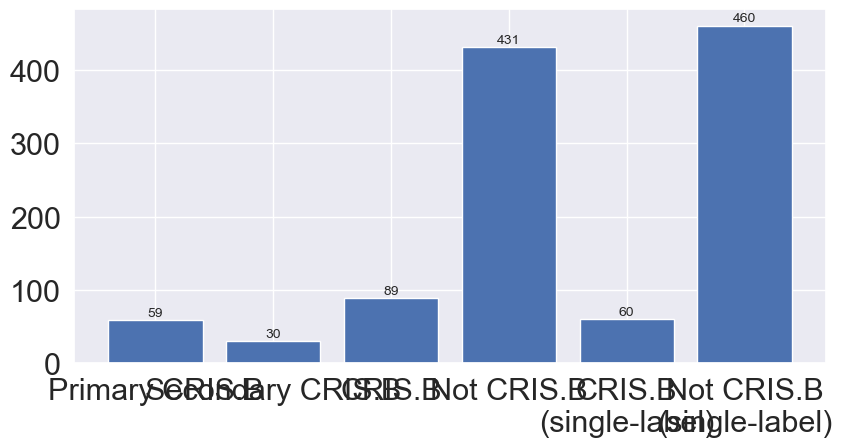

In [194]:
# Create groups
def create_groups(df: pd.DataFrame):
    group_not_LumA = df[df['IS CRIS.B'] == False]
    group_LumA = df[df['IS CRIS.B'] == True]
    group_LumA_primary = df[df['IS CRIS.B PRIMARY'] == True]
    group_LumA_secondary = df[df['IS CRIS.B SECONDARY'] == True]
    group_not_LumA_single = df[df['IS CRIS.B (single-label)'] == False]
    group_LumA_single = df[df['IS CRIS.B (single-label)'] == True]

    counts = [group_LumA_primary.shape[0], group_LumA_secondary.shape[0], 
              group_LumA.shape[0], group_not_LumA.shape[0], 
            group_LumA_single.shape[0], group_not_LumA_single.shape[0]]
    labels = ['Primary CRIS.B', 'Secondary CRIS.B', 'CRIS.B', 'Not CRIS.B', 'CRIS.B\n(single-label)', 'Not CRIS.B\n(single-label)']

    # Create a bar plot
    plt.figure(figsize=(9,5))
    plt.bar(range(len(counts)), counts, tick_label=labels)

    # Add exact numbers as annotations above the bars
    for i, v in enumerate(counts):
        plt.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()

    return group_not_LumA, group_LumA, group_LumA_primary, group_LumA_secondary, group_not_LumA_single, group_LumA_single

group_not_CRISB, group_CRISB, group_CRISB_primary, group_CRISB_secondary, group_not_CRISB_single, group_CRISB_single = create_groups(df_xgb_lp)

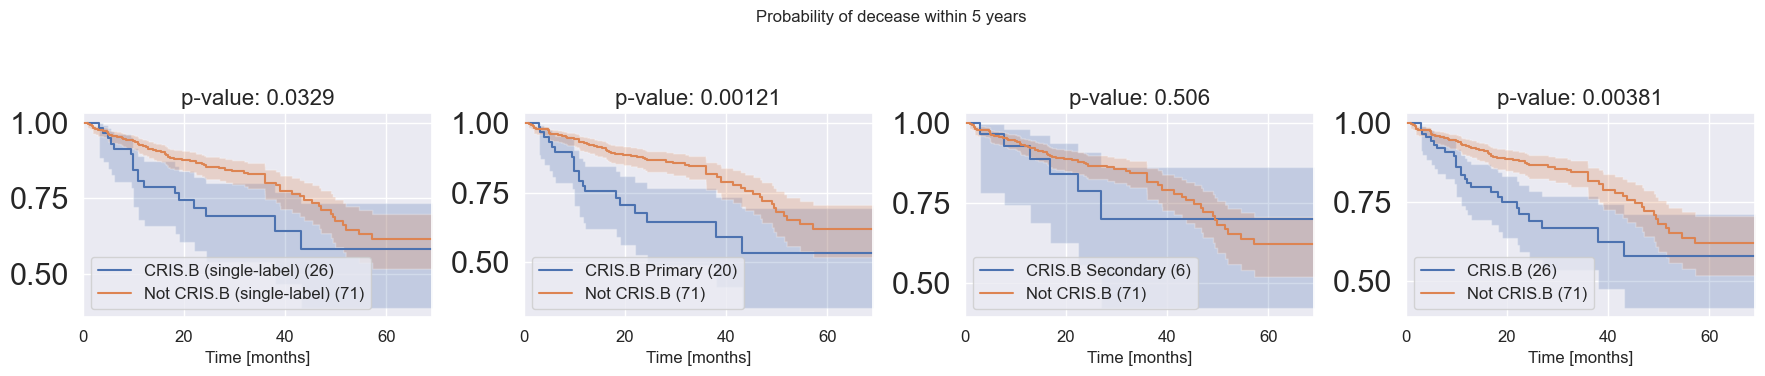

In [195]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from lifelines.statistics import logrank_test
from matplotlib.offsetbox import AnchoredText

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
axes = axes.flatten()
group_names = ['CRIS.B Primary', 'CRIS.B Secondary', 'CRIS.B']
mask = 'DECEASED WITHIN 5 YEARS' # ALIVE FOR MORE THAN 5 YEARS

for i, df_group in enumerate([group_CRISB_primary, group_CRISB_secondary, group_CRISB]):

    # Compute cardinality of health status vs group
    positive_counts = (df_group[mask]).sum()
    negative_count = group_not_CRISB[mask].sum()

    e1, t1 = df_group[mask].astype('bool'), df_group['overall_survival_months_consensus']
    e2, t2 = group_not_CRISB[mask].astype('bool'), group_not_CRISB['overall_survival_months_consensus']

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=e1,
        time_exit=t1, 
        conf_type='log-log'
    )

    time_not_CRISB, survival_prob_not_CRISB, conf_int_not_CRISB = kaplan_meier_estimator(
        event=e2,
        time_exit=t2, 
        conf_type='log-log'
    )
    p_value = logrank_test(t1, t2, e1, e2).p_value

    axes[i+1].step(time, survival_prob, where='post', label=group_names[i] + ' ({})'.format(positive_counts))
    axes[i+1].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i+1].step(time_not_CRISB, survival_prob_not_CRISB, where='post', label='Not CRIS.B ({})'.format(negative_count))
    axes[i+1].fill_between(time_not_CRISB, conf_int_not_CRISB[0], conf_int_not_CRISB[1], alpha=0.25, step="post")

    axes[i+1].set_xlabel('Time [months]', fontsize=12)
    axes[i+1].legend(loc='best', fontsize=12)
    axes[i+1].xaxis.set_tick_params(labelsize=12)
    axes[i+1].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
    axes[i+1].set_xlim([0, 69]) # [51, max(time_not_LumA[-1], time[-1])]

# Compute cardinality of health status vs group
positive_counts = df_group[mask].sum()
negative_count = group_not_CRISB[mask].sum()

e1, t1 = group_CRISB_single[mask].astype('bool'), group_CRISB_single['overall_survival_months_consensus']
e2, t2 = group_not_CRISB_single[mask].astype('bool'), group_not_CRISB_single['overall_survival_months_consensus']

time, survival_prob, conf_int = kaplan_meier_estimator(
    event=e1,
    time_exit=t1, 
    conf_type='log-log'
)

time_not_CRISB, survival_prob_not_CRISB, conf_int_not_CRISB = kaplan_meier_estimator(
    event=e2,
    time_exit=t2, 
    conf_type='log-log'
)
p_value = logrank_test(t1, t2, e1, e2).p_value

axes[0].step(time, survival_prob, where='post', label='CRIS.B (single-label) ({})'.format(positive_counts))
axes[0].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
axes[0].step(time_not_CRISB, survival_prob_not_CRISB, where='post', label='Not CRIS.B (single-label) ({})'.format(negative_count))
axes[0].fill_between(time_not_CRISB, conf_int_not_CRISB[0], conf_int_not_CRISB[1], alpha=0.25, step="post")

axes[0].set_xlabel('Time [months]', fontsize=12)
axes[0].legend(fontsize=12)
axes[0].xaxis.set_tick_params(labelsize=12)
axes[0].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
axes[0].set_xlim([0, 69]) # max(time_not_LumA[-1], time[-1]

fig.suptitle('Probability of decease within 5 years', fontsize=12)
plt.tight_layout()

When the p-value is not less than 0.05, we fail to reject the null hypothesis and conclude that the survival curves are not significantly different. Therefore, the prediction of LumA or LumA as a primary or secondary class did not help patients live longer.

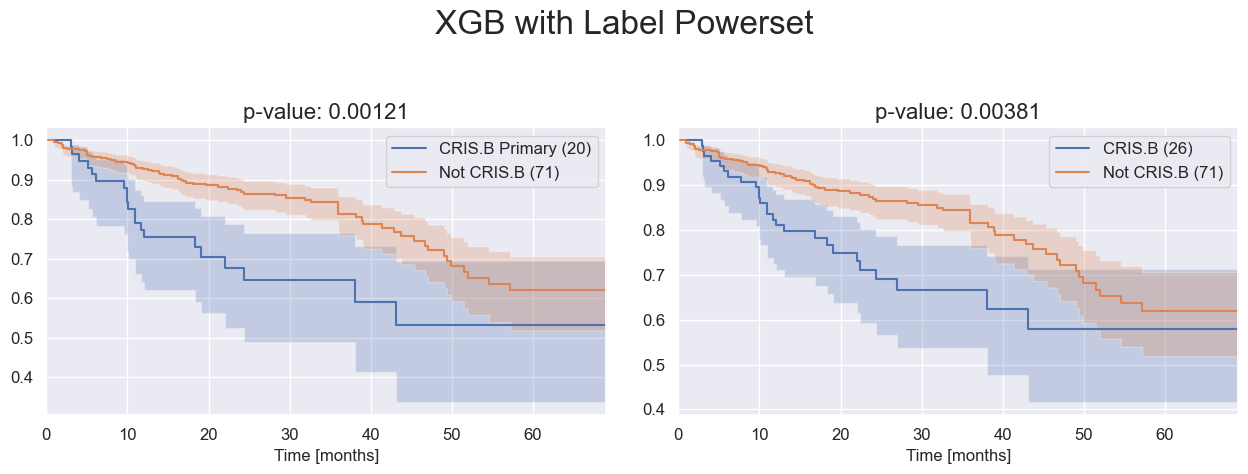

In [201]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from lifelines.statistics import logrank_test
from matplotlib.offsetbox import AnchoredText

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
axes = axes.flatten()
group_names = ['CRIS.B Primary', 'CRIS.B']
mask = 'DECEASED WITHIN 5 YEARS' # ALIVE FOR MORE THAN 5 YEARS

for i, df_group in enumerate([group_CRISB_primary, group_CRISB]):

    # Compute cardinality of health status vs group
    positive_counts = (df_group[mask]).sum()
    negative_count = group_not_CRISB[mask].sum()

    e1, t1 = df_group[mask].astype('bool'), df_group['overall_survival_months_consensus']
    e2, t2 = group_not_CRISB[mask].astype('bool'), group_not_CRISB['overall_survival_months_consensus']

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=e1,
        time_exit=t1, 
        conf_type='log-log'
    )

    time_not_CRISB, survival_prob_not_CRISB, conf_int_not_CRISB = kaplan_meier_estimator(
        event=e2,
        time_exit=t2, 
        conf_type='log-log'
    )
    p_value = logrank_test(t1, t2, e1, e2).p_value

    axes[i].step(time, survival_prob, where='post', label=group_names[i] + ' ({})'.format(positive_counts))
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_CRISB, survival_prob_not_CRISB, where='post', label='Not CRIS.B ({})'.format(negative_count))
    axes[i].fill_between(time_not_CRISB, conf_int_not_CRISB[0], conf_int_not_CRISB[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=12)
    axes[i].legend(loc='best', fontsize=12)
    axes[i].xaxis.set_tick_params(labelsize=12)
    axes[i].yaxis.set_tick_params(labelsize=12)
    axes[i].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
    axes[i].set_xlim([0, 69]) # [51, max(time_not_LumA[-1], time[-1])]

# Compute cardinality of health status vs group
positive_counts = df_group[mask].sum()
negative_count = group_not_CRISB[mask].sum()

e1, t1 = group_CRISB_single[mask].astype('bool'), group_CRISB_single['overall_survival_months_consensus']
e2, t2 = group_not_CRISB_single[mask].astype('bool'), group_not_CRISB_single['overall_survival_months_consensus']

time, survival_prob, conf_int = kaplan_meier_estimator(
    event=e1,
    time_exit=t1, 
    conf_type='log-log'
)

time_not_CRISB, survival_prob_not_CRISB, conf_int_not_CRISB = kaplan_meier_estimator(
    event=e2,
    time_exit=t2, 
    conf_type='log-log'
)
p_value = logrank_test(t1, t2, e1, e2).p_value

# axes[0].step(time, survival_prob, where='post', label='CRIS.B (single-label) ({})'.format(positive_counts))
# axes[0].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
# axes[0].step(time_not_CRISB, survival_prob_not_CRISB, where='post', label='Not CRIS.B (single-label) ({})'.format(negative_count))
# axes[0].fill_between(time_not_CRISB, conf_int_not_CRISB[0], conf_int_not_CRISB[1], alpha=0.25, step="post")

# axes[0].set_xlabel('Time [months]', fontsize=12)
# axes[0].legend(fontsize=12)
# axes[0].xaxis.set_tick_params(labelsize=12)
# axes[0].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
# axes[0].set_xlim([0, 69]) # max(time_not_LumA[-1], time[-1]

fig.suptitle('XGB with Label Powerset', fontsize=24)
plt.tight_layout()